In [ ]:
import numpy as np
import sys
import scipy

class LBM_2_Carlemann1:
    def __init__(self, N_grid, h_init, u_init):
        # Constants for the D1Q3 lattice (1D, 3 velocities)
        self.w = np.array([2/3, 1/6, 1/6])  # Weights for D1Q3 lattice
        self.e = np.array([0, 1, -1])  # Lattice directions: [0, +1, -1]
        self.c_s = 1/np.sqrt(3)  # Speed of sound for D1Q3 lattice...is this the delta_x\delta_t ??
        self.kn = 0.1 #Knudsen number, much less than 1 for chapman-enskogg expansion

        # Parameters
        self.tau = 1.0  # Relaxation time
        self.nu = 0.08  # dissipation rate
        self.Nx = N_grid  # Number of grid points...my code for the F matrices makes the kernel die if this number is 81 or higher
        self.L = 0.0001 # Length of the domain (in meters)
        #self.delta_t = self.L/self.Nx
        self.dx = self.L/self.Nx
        self.delta_t = (self.dx*self.c_s**2)/np.sqrt(h_init[-1]*9.81)
        self.g = 9.81*(self.delta_t**2/self.dx)  # Acceleration due to gravity (m/s^2)

        # Initialize macroscopic variables: density(height) and velocity field
        self.h = h_init  # height field
        self.u = u_init  # Velocity field

        # Initialize distribution functions (f_i), f has 3 directions (D1Q3)
        self.f = np.zeros((self.Nx, 3))  # Distribution functions for D1Q3
        self.feq = np.zeros_like(self.f)  # Equilibrium distribution functions

     #return a 1D array with one non-zero element of value 1 at specified index
    def one_nonzero(self,dim, n):
        array = np.zeros((dim))
        if n>-1 and n<dim:
            array[n] = 1
        return array
    #make the F matrices for the collision matrix for n grid points
    def gen_F(self):
        f1 = np.zeros((3,3))
        f1[0,1] = f1[0,2] = 1
        f1[1,1] = 1/(2*self.c_s) - 1
        f1[1,2] = -1/(2*self.c_s)
        f1[2,1] = -1/(2*self.c_s)
        f1[2,2] = 1/(2*self.c_s) -1
        f1 = (1/(self.tau*self.kn))*f1
        
        f2 = np.zeros((3,9))
        for i in range(9):
            f2[0,i] = -self.g
            f2[1,i]  = self.g
            f2[2,i]  = self.g
        f2[0,4] = f2[0,4] -4 
        f2[0,8] = f2[0,8] -4
        f2[0,5] = f2[0,5] +4 
        f2[0,7] = f2[0,7] +4
        for i in range(2):
            f2[i+1, 4] = f2[i+1, 4] +2
            f2[i+1, 8] = f2[i+1, 8] +2

            f2[i+1, 5] = f2[i+1, 5] -2
            f2[i+1, 7] = f2[i+1, 7] -2
        f2 = (1/(2*self.tau*self.kn*self.c_s**2))*f2

        f3 = np.zeros((3,9))
        f3[0,4] = 2
        f3[0,8] = 2
        f3[0,5] = -2 
        f3[0,7] = -2
        for i in range(2):
            f3[i+1, 4] = -1
            f3[i+1, 8] = -1

            f3[i+1, 5] = 1
            f3[i+1, 7] = 1
        f3 = np.hstack((f3,f3,f3))
        f3 = (1/(2*self.tau*self.kn*self.c_s**2))*f3

        #generalise to n grid points...strategy is to stack matrices, not create matrix of matrices I think...?
        n = self.Nx
        Q = len(self.e)
        '''
        F1 = np.zeros((dim,Q, dim*Q))
        F2 = np.zeros((dim,Q, (dim**2)*(Q**2)))
        F3 = np.zeros((dim,Q, (dim**3)*(Q**3)))
        '''
        I = self.one_nonzero(n, 0)
        F1 = np.kron(I, f1)
        F2 = np.kron(np.kron(I,I) , f2)
        F3 = np.kron(np.kron(np.kron(I, I), I), f3)


        for i in range(n-1):
            I = self.one_nonzero(n, i+1)
            F1 = np.vstack((F1, np.kron(I, f1)))
            F2 = np.vstack((F2, np.kron(np.kron(I,I) , f2)))
            F3 = np.vstack((F3, np.kron(np.kron(np.kron(I, I), I), f3)))
        
        return F1,F2,F3, f1, f2, f3
        
    #make A matrices for the collision matrix
    def gen_A(self, F1,F2,F3):
        A11 = F1
        A12 = F2
        A13 = F3
        Q= len(self.e)
        n = self.Nx
        dim = n*Q
        I = np.identity(dim)
        A22 = np.kron(F1,I) + np.kron(I, F1)
        #slows down at A22, kernel dies after with Nx = 50
        A23 = np.kron(F2,I) + np.kron(I, F2)
        A33 = np.kron(np.kron(F1,I), I) + np.kron(np.kron(I,F1), I) + np.kron(np.kron(I,I), F1)

        return A11, A12, A13, A22, A23, A33
    #make collision matrix 
    def gen_collision(self, A11, A12, A13, A22, A23, A33):
        C1 = np.vstack((A11,np.zeros((A22.shape[0]+A33.shape[0],A11.shape[1]))))
        C2 = np.vstack((A12,A22,np.zeros((A33.shape[0],A12.shape[1]))))
        C3 = np.vstack((A13, A23, A33))

        Cc = np.hstack((C1,C2,C3))

        return Cc
    
    #make streaming matrix, restricted to NN, 2nd order accuracy...only makes sense if we are considering more than 1 grid point
    def gen_streaming(self):
        Q= len(self.e)
        n = self.Nx
        inv_delta = n/(2*self.L)
        dim = n*Q
        I = np.identity(dim)
        S = np.zeros((dim, dim))
        print("S shape",S.shape)
        for i in range(dim):
            #deal with edge case here...periodic or bounce back BC...here I do code for periodic
            if i<Q:
                S[i,i+Q] = inv_delta*self.e[(i%3)]
                S[i, (dim-Q)+i] = -inv_delta*self.e[(i%3)]
            elif i>dim -Q - 1:
                S[i,dim-i] = inv_delta*self.e[(i%3)]
                S[i,i-Q] = -inv_delta*self.e[(i%3)]
            else:
                S[i,i+Q] = inv_delta*self.e[(i%3)]
                S[i,i-Q] = -inv_delta*self.e[(i%3)]


        B11 = S
        B22 = np.kron(S,I) + np.kron(I, S)
        B33 = np.kron(np.kron(S,I), I) + np.kron(np.kron(I,S), I) + np.kron(np.kron(I,I), S)

        C1 = np.vstack((B11,np.zeros((B22.shape[0]+B33.shape[0],B11.shape[1]))))
        C2 = np.vstack((np.zeros((B11.shape[0],B22.shape[1])),B22,np.zeros((B33.shape[0],B22.shape[1]))))
        C3 = np.vstack((np.zeros((B11.shape[0]+B22.shape[0],B33.shape[1])), B33))

        Cs = np.hstack((C1,C2,C3))

        return Cs, B11,B22,B33,S

In [146]:
N_grid = 4
h_init = [0.5,0.5,1,1]
u_init = [0,0,0,0]

Gen = LBM_2_Carlemann1(N_grid, h_init, u_init )

F1,F2,F3, f1,f2,f3  = Gen.gen_F()

A11, A12, A13, A22, A23, A33 = Gen.gen_A(F1,F2,F3)

Cc = Gen.gen_collision(A11, A12, A13, A22, A23, A33)
Cs, B11,B22,B33,S = Gen.gen_streaming()

CL_LBE_Matrix = Cc + Cs

S shape (12, 12)


In [147]:
def embed_matrix(C, delta_t, num_steps):
    """
    Embeds a matrix C into a larger matrix A with specified properties.

    Parameters:
        C (np.ndarray): The matrix to embed (must be square).
        delta_t (float): The length of each time step.
        num_steps (int): The number of time steps (and thus of cascaded blocks in A).

    Returns:
        np.ndarray: The constructed matrix A.
    """
    # Validate inputs
    if not (isinstance(C, np.ndarray) and C.ndim == 2 and C.shape[0] == C.shape[1]):
        raise ValueError("C must be a square matrix.")

    # Identity matrix with the same size as C
    Id = np.eye(C.shape[0])

    # Compute -O = -(Id + delta_t * C)
    O = -(Id + delta_t * C)

    # Size of the large matrix A
    A_size = num_steps * C.shape[0]

    # Initialize A as a zero matrix
    A = np.zeros((A_size, A_size))

    # Fill in the diagonal blocks
    for i in range(num_steps):
        # Main diagonal (Identity blocks)
        start_idx = i * C.shape[0]
        A[start_idx:start_idx + C.shape[0], start_idx:start_idx + C.shape[0]] = Id

        # Secondary diagonal (-O blocks)
        if i > 0:
            prev_idx = (i - 1) * C.shape[0]
            A[start_idx:start_idx + C.shape[0], prev_idx:prev_idx + C.shape[0]] = O

    return A

In [148]:
N_time = 8  # Number of time steps
delta_t = Gen.delta_t
Lin_Euler_Matrix = embed_matrix(CL_LBE_Matrix, delta_t, N_time)
print("Shape of the Matrix to invert:", Lin_Euler_Matrix.shape)

Shape of the Matrix to invert: (15072, 15072)


In [149]:
def initial_distribution(Nx,h,u):

    #if velocities are null everywhere
    #initial_distribution = np.kron(Gen.h,(1/6,2/3,1/6))

    distr = np.zeros((Nx,3))

    for g in range (Nx):
        for i in range(3):
            if i==0:
                distr[g,i]= h[g]*(1/6 - u[g]/2)
            if i==1:
                distr[g,i]= h[g]*2/3
            if i==2:
                distr[g,i]= h[g]*(1/6 + u[g]/2)
            
    initial_distribution = np.hstack([distr[g,:] for g in range (Gen.Nx)])  # Function of 3 values in the 1D case
    
    return initial_distribution


def append_zeros(f, N):
    # Ensure `f` is a NumPy array
    f = np.array(f)

    # Create N zero vectors of the same shape as `f`
    zero_vector = np.zeros_like(f)
    zeros_to_append = np.tile(zero_vector, (N-1,))

    # Concatenate `f` with the appended zeros
    result = np.concatenate([f, zeros_to_append])

    return result

In [150]:
f1 = initial_distribution(Gen.Nx, Gen.h, Gen.u)
f2 = np.kron(f1,f1)
f3 = np.kron(f2,f1)

phi_t0 = np.hstack((f1,f2,f3))

phi = append_zeros(phi_t0, N_time)

In [151]:
#eigenvalues, _ = np.linalg.eig(Lin_Euler_Matrix)

#smallest_eigenvalue = np.min(eigenvalues)
#print(f"The smallest eigenvalue is: {smallest_eigenvalue}")

In [152]:
#cond_number = np.linalg.cond(Lin_Euler_Matrix)
#print(f"The condition number of the matrix is: {cond_number}")

In [153]:
Inverted_matrix = np.linalg.inv(Lin_Euler_Matrix)
x = np.dot(Inverted_matrix, phi)

In [154]:
def extract_phi(x, subvector_dim, N):
    if len(x) < N * subvector_dim:
        raise ValueError("The length of x is too small for the given N and subvector_dim.") 
    # Extract phi components
    phi = [x[i * subvector_dim : (i + 1) * subvector_dim] for i in range(N)]
    return phi

def phi_truncation(phi_list, N):
    num_values = 3 * N
    truncated_phi = [phi[:num_values] for phi in phi_list]
    return truncated_phi

def divide_truncated_phi(truncated_phi, N):
    result = []
    for phi in truncated_phi:
        # Ensure the truncated phi has at least 3 * N elements
        if len(phi) < 3 * N:
            raise ValueError("Each truncated phi must have at least 3 * N elements.")
        
        # Divide phi into N groups of 3
        groups = [phi[3 * i : 3 * (i + 1)] for i in range(N)]
        result.extend(groups)
    
    return result 


In [155]:
# x = np.arange(10845)  # Example: [0, 1, 2, ..., 10844]
N_grid = Gen.Nx

grid_evolution = np.zeros((N_grid,N_time,3))

subvector_dim = 3 * N_grid + 9 * N_grid**2 + 27 * N_grid**3
print("Subvector dimension:", subvector_dim)

# Extract phi components for each time step
phi = extract_phi(x, subvector_dim, N_time)

# Extract the first 3 * N values from each phi_i
truncated_phi = phi_truncation(phi, N_grid)

# Divide each truncated phi into N groups of 3 and combine them
three_dim_vectors = divide_truncated_phi(truncated_phi, N_grid)

# Display the results
for i, vec in enumerate(three_dim_vectors, start=0):
    print(f"Grid {i % Gen.Nx} at time { i // Gen.Nx}: {vec}")
    grid_evolution[i % Gen.Nx, i // Gen.Nx,:] = vec


Subvector dimension: 1884
Grid 0 at time 0: [0.08333333 0.33333333 0.08333333]
Grid 1 at time 0: [0.08333333 0.33333333 0.08333333]
Grid 2 at time 0: [0.16666667 0.66666667 0.16666667]
Grid 3 at time 0: [0.16666667 0.66666667 0.16666667]
Grid 0 at time 1: [0.08334858 0.31559062 0.08775766]
Grid 1 at time 1: [0.08334386 0.35106803 0.07889125]
Grid 2 at time 1: [0.16665752 0.68441363 0.16223199]
Grid 3 at time 1: [0.16669272 0.63561784 0.15778001]
Grid 0 at time 2: [0.08336326 0.30044387 0.09194597]
Grid 1 at time 2: [0.08335674 0.37069026 0.0749192 ]
Grid 2 at time 2: [0.16664842 0.6995649  0.15803358]
Grid 3 at time 2: [0.1667157  0.60386141 0.14960326]
Grid 0 at time 3: [0.08337743 0.28803118 0.09591099]
Grid 1 at time 3: [0.0833722  0.39192367 0.07139189]
Grid 2 at time 3: [0.16663969 0.71198217 0.15405854]
Grid 3 at time 3: [0.16673589 0.57152277 0.14201072]
Grid 0 at time 4: [0.08339111 0.27846928 0.09966009]
Grid 1 at time 4: [0.0833905  0.41447716 0.06828544]
Grid 2 at time 4: [0

Timestep 0
Grid 0 height: 0.49999999999999994
Grid 1 height: 0.49999999999999994
Grid 2 height: 0.9999999999999999
Grid 3 height: 0.9999999999999999

Timestep 1
Grid 0 height: 0.4866968571681827
Grid 1 height: 0.5133031428964852
Grid 2 height: 1.0133031430073447
Grid 3 height: 0.9600905714953102

Timestep 2
Grid 0 height: 0.47575310335841503
Grid 1 height: 0.5289661930311879
Grid 2 height: 1.0242468969942453
Grid 3 height: 0.920180365665869

Timestep 3
Grid 0 height: 0.46731959817918
Grid 1 height: 0.5466877574077594
Grid 2 height: 1.0326804023514546
Grid 3 height: 0.8802693824967586

Timestep 4
Grid 0 height: 0.4615204776037505
Grid 1 height: 0.5661530988629149
Grid 2 height: 1.038479523104899
Grid 3 height: 0.8403576219730169

Timestep 5
Grid 0 height: 0.45845144310142694
Grid 1 height: 0.5870358425395504
Grid 2 height: 1.0415485577844512
Grid 3 height: 0.8004450840796317

Timestep 6
Grid 0 height: 0.45817835349214736
Grid 1 height: 0.6089997580248048
Grid 2 height: 1.041821647569326

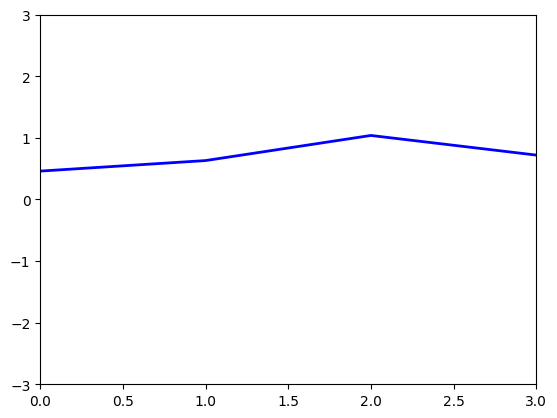

In [156]:
#heigth
h = np.zeros((N_grid,N_time))

for t in range (N_time):
    print("Timestep", t)
    for g in range (N_grid):
        h[g, t] = sum(grid_evolution[g,t,:])
        print(f"Grid {g} height: {h[g,t]}")
    print("")
    

import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Example 2D array of heights: rows are timesteps (t), columns are grid points (g)
timesteps = N_time
grid_points = Gen.Nx

# Set up the figure and axis
fig, ax = plt.subplots()
ax.set_xlim([0, grid_points - 1])  # Set x-axis limits to the number of grid points
ax.set_ylim(-3, 3)  # Adjust the y-axis to fit the height data

# Initialize the line object (empty initially)
line, = ax.plot([], [], lw=2, color='blue')  # Line object to plot the profile
x = np.arange(grid_points)  # x values represent the grid points (g)

# Animation function: updates the line plot with heights at each timestep
def animate(t):
    y = h[:, t]  # Heights at all grid points for timestep t
    line.set_data(x, y)  # Set the x and y data for the line plot
    return line,

# Create the animation
ani = animation.FuncAnimation(fig, animate, repeat=True,
                              frames=timesteps, interval=10000)

# To save the animation as a gif using Pillow
writer = animation.PillowWriter(fps=0.5)

ani.save('height_profile.gif', writer=writer)

plt.show()
